# Detecção de comunidades


In [18]:
# #Bibliotecas necessárias
# !pip install python-louvain
# !pip install leidenalg
# !pip install cairocffi
# !pip install --upgrade scipy
# !pip install --upgrade networkx[default]

# #No linux precisei instalar antes do pycairo: sudo apt install libcairo2-dev pkg-config python3-dev
# !pip install pycairo

In [19]:
%reload_ext autoreload
%autoreload 2

import community as community_louvain
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import colormaps
import sys
from itertools import combinations
from datetime import datetime
import pandas as pd
import numpy as np
sys.path.append('../utils')
from mapa_estudantes import get_historico_completo, gerar_estudantes, get_disciplinas_matriz_844
from disciplina import trilhas

import leidenalg as la
import igraph as ig

def printall(string):
    pd.set_option('display.max_rows', None)
    print(string)
    pd.set_option('display.max_rows', 15)

In [20]:
dados_estudantes = [
    # "../excel/dados_historicos_alunos_de_EngComputacaoCuritiba desistentes mudancas curso.csv",
    "../excel/dados_historicos_alunos_de_EngComputacaoCuritiba formados.csv",
    "../excel/dados_historicos_alunos_de_EngComputacaoCuritiba regulares.csv",
    # "../excel/dados_historicos_alunos_de_EngComputacaoCuritiba trancados.csv",
]

dfs = []
for file in dados_estudantes:
    dfs.append(pd.read_csv(file, delimiter=";"))

df = pd.concat(dfs, ignore_index=True)
df.rename(
    columns={"PERIODO": "PERIODO_CURSO", "PERIODO.1": "PERIODO_ANO"}, inplace=True
)
# df["INGRESSO"] = pd.to_datetime(df["INGRESSO"], format="%d/%m/%y")
df["INGRESSO"] = pd.to_datetime(df["INGRESSO"], format="mixed")
df["SEMESTRE"] = df["ANO"].astype(str) + "." + df["PERIODO_ANO"].astype(str)
pd.set_option("display.width", 1000)
# pd.set_option('display.max_rows', None)
print(df)

       ID_ANONIMO      CR PERIODO_CURSO   INGRESSO  CODIGO   ANO  PERIODO_ANO NOTA  CH SITUACAOALUNO SEMESTRE
0           13236  0,6826            10 2007-12-07   IF68E  2012            1  8,2  60       Formado   2012.1
1           13236  0,6826            10 2007-12-07   IF35J  2007            2    7  60       Formado   2007.2
2           13236  0,6826            10 2007-12-07   MA33K  2007            2    0  60       Formado   2007.2
3           13236  0,6826            10 2007-12-07  F2D070  2007            2  8,8  75       Formado   2007.2
4           13236  0,6826            10 2007-12-07  E1D000  2007            2    0  30       Formado   2007.2
...           ...     ...           ...        ...     ...   ...          ...  ...  ..           ...      ...
50021      261036   0,695             2 2023-09-08  ICSF13  2023            2  6,6  90       Regular   2023.2
50022      261911  0,7143             1 2023-08-17  ICSD21  2023            2    8  45       Regular   2023.2
50023     

In [21]:
# Obter os dados da matriz 844
disciplinas_844 = get_disciplinas_matriz_844()
disciplinas_844

{'CSD20': Disciplina(periodo=1, trilha=None, codigo='CSD20', disciplina='INTRODUÇÃO À LÓGICA PARA A COMPUTAÇÃO', modelo_disciplina='FORMAÇÃO PROFISSIONAL', aulas_teoricas_semanais=3, aulas_praticas_semanais=0, total_de_aulas_semanais=3, total_de_aulas_de_aps=3, total_de_aulas_de_apcc=0, total_de_horas_de_ad=6, carga_horaria_total=45, pre_requisitos=[], disciplinas_equivalentes={'ICSD20': 45, 'IF61B': 60}),
 'CSF13': Disciplina(periodo=1, trilha=None, codigo='CSF13', disciplina='FUNDAMENTOS DE PROGRAMAÇÃO 1', modelo_disciplina='FORMAÇÃO PROFISSIONAL', aulas_teoricas_semanais=3, aulas_praticas_semanais=3, total_de_aulas_semanais=6, total_de_aulas_de_aps=6, total_de_aulas_de_apcc=0, total_de_horas_de_ad=0, carga_horaria_total=90, pre_requisitos=[], disciplinas_equivalentes={'ICSF13': 90, 'IF61C': 90}),
 'FI71S': Disciplina(periodo=1, trilha=None, codigo='FI71S', disciplina='FÍSICA TEÓRICA A', modelo_disciplina='FORMAÇÃO BÁSICA E CIENTÍFICA', aulas_teoricas_semanais=4, aulas_praticas_seman

In [22]:
# Obter um mapeamento de disciplinas equivalentes
mapeamento_equivalentes = {}
for disciplina in disciplinas_844.values():
    for equivalente in disciplina.disciplinas_equivalentes.keys():
        mapeamento_equivalentes[equivalente] = disciplina.codigo

mapeamento_equivalentes

{'ICSD20': 'CSD20',
 'IF61B': 'CSD20',
 'ICSF13': 'CSF13',
 'IF61C': 'CSF13',
 'FIS7F1': 'FI71S',
 'FI71M': 'FI71S',
 'FI71Z': 'FI71S',
 'MAT7C1': 'MA71A',
 'MA61A': 'MA71A',
 'MA71Z': 'MA71A',
 'MAT7AL': 'MA71B',
 'MAT7GA': 'MA71B',
 'MA61B': 'MA71B',
 'MA71I': 'MA71B',
 'MA71Y': 'MA71B',
 'MA72I': 'MA71B',
 'ICSE20': 'CSE20',
 'IF62C': 'CSE20',
 'ICSF20': 'CSF20',
 'IF62E': 'CSF20',
 'ELEX10': 'EEX11',
 'ELE11': 'EEX11',
 'FIS7E1': 'FI72N',
 'FI61A': 'FI72N',
 'FI62A': 'FI72N',
 'FI71A': 'FI72N',
 'FI71Y': 'FI72N',
 'FI72A': 'FI72N',
 'FI72B': 'FI72N',
 'FIS7F2': 'FI72S',
 'FI72M': 'FI72S',
 'FI72Z': 'FI72S',
 'MA62A': 'MA72A',
 'MA72H': 'MA72A',
 'MA75D': 'MA72A',
 'QBI7QE': 'QB70C',
 'QBI7QT': 'QB70C',
 'QB64A': 'QB70C',
 'QB70D': 'QB70C',
 'QB70I': 'QB70C',
 'ICSF30': 'CSF30',
 'IF63C': 'CSF30',
 'ELEB20': 'EEB21',
 'ELP21': 'EEB21',
 'EL63A': 'EEB21',
 'EL72F': 'EEB21',
 'ELEX20': 'EEX21',
 'ELE41': 'EEX21',
 'ELX91': 'EEX21',
 'FIS7F3': 'FI73S',
 'FI73M': 'FI73S',
 'FI74K': 'MA7

In [23]:
# Obter nome de disciplinas eletivas
eletivas = pd.read_csv("../excel/Eletivas.csv", delimiter=",")
mapa_eletivas = {}
for index, row in eletivas.iterrows():
    mapa_eletivas[row["CODIGO"]] = row["DISCIPLINA"]

print(mapa_eletivas)

{'CE70B': 'Comunicação oral e escrita', 'EL71D': 'Introdução à Engenharia Mecatrônica', 'DI81B': 'Criatividade', 'DI61B': 'História da Arte 1', 'GE73H': 'Comportamento Humano Nas Organizações', 'CL73A': 'Letras Inglês Básico 2', 'CL74A': 'Língua Inglesa – Intermediário 1', 'ME66J': 'Metodologia de Projetos', 'FI70C': 'Princípios de Resistências dos Materiais', 'EL64G': 'Metrologia Elétrica', 'EL64E': 'Materiais e Dispositivos', 'MA74C': 'Cálculo Diferencial e Integral IV B', 'DI81A': 'História da Arte', 'ED70Q': 'Didática 1', 'MA77J': 'História da Matemática A', 'DI62G': 'Computação Gráfica 1', 'DI64G': 'Fotografia', 'DI65H': 'Fundamentos de Interação', 'MA75K': 'Fundamentos de Álgebra', 'ES70Q': 'Sociedade e Política no Brasil', 'GE73D': 'Instituições De Direito'}


In [24]:
def get_tipo_disciplina(disciplina):
    if disciplina in disciplinas_844:
        return (
            disciplinas_844[disciplina].trilha
            if disciplinas_844[disciplina].trilha
            else "OBRIGATÓRIA"
        )
    elif disciplina in mapa_eletivas:
        return "ELETIVA"
    else:
        return "NÃO MAPEADA"


df = df.replace({"CODIGO": mapeamento_equivalentes})
df["DISCIPLINA"] = df["CODIGO"].apply(
    lambda x: disciplinas_844[x].disciplina if x in disciplinas_844 else None
)
df["TRILHA"] = df["CODIGO"].apply(get_tipo_disciplina)

In [25]:
df_844 = df.loc[
    (df["INGRESSO"] >= datetime(2017, 1, 1)) & (df["INGRESSO"] <= datetime(2023, 1, 1))
]
print(f'Alunos na matriz 844: {df_844["ID_ANONIMO"].unique().size}')

# pd.set_option('display.max_rows', None)
pd.set_option("display.max_rows", 15)
df_844

Alunos na matriz 844: 326


,ID_ANONIMO,CR,PERIODO_CURSO,INGRESSO,CODIGO,ANO,PERIODO_ANO,NOTA,CH,SITUACAOALUNO,SEMESTRE,DISCIPLINA,TRILHA
20694,145077,"0,7908",10,2017-02-03,QB70E,2022,1,9,30,Formado,2022.1,CIÊNCIAS DO AMBIENTE,OBRIGATÓRIA
20695,145077,"0,7908",10,2017-02-03,ES70P,2020,2,"7,2",45,Formado,2020.2,FILOSOFIA DA CIÊNCIA E DA TECNOLOGIA,OBRIGATÓRIA
20696,145077,"0,7908",10,2017-02-03,MA71A,2017,1,"9,2",90,Formado,2017.1,CÁLCULO DIFERENCIAL E INTEGRAL 1,OBRIGATÓRIA
20697,145077,"0,7908",10,2017-02-03,FI72S,2018,1,"8,9",60,Formado,2018.1,FÍSICA TEÓRICA B,OBRIGATÓRIA
20698,145077,"0,7908",10,2017-02-03,FI72S,2017,2,4,60,Formado,2017.2,FÍSICA TEÓRICA B,OBRIGATÓRIA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49725,251700,"0,6279",2,2022-08-25,CSF13,2022,2,"4,2",90,Regular,2022.2,FUNDAMENTOS DE PROGRAMAÇÃO 1,OBRIGATÓRIA
49726,251700,"0,6279",2,2022-08-25,MA71A,2022,2,6,90,Regular,2022.2,CÁLCULO DIFERENCIAL E INTEGRAL 1,OBRIGATÓRIA
49727,251700,"0,6279",2,2022-08-25,FI71S,2022,2,"2,9",60,Regular,2022.2,FÍSICA TEÓRICA A,OBRIGATÓRIA
49728,251700,"0,6279",2,2022-08-25,MA71B,2022,2,6,90,Regular,2022.2,GEOMETRIA ANALÍTICA E ÁLGEBRA LINEAR,OBRIGATÓRIA


In [26]:
# Disciplinas eletivas de alunos da matriz 844
eletivas = list(df_844.loc[df_844["DISCIPLINA"].isna()]["CODIGO"].unique())
for eletiva in eletivas:
    print(
        f'{eletiva} - {mapa_eletivas[eletiva] if eletiva in mapa_eletivas else "NÃO MAPEADA"}'
    )

CE70B - Comunicação oral e escrita
EL71D - Introdução à Engenharia Mecatrônica
DI81B - Criatividade
DI61B - História da Arte 1
GE73H - Comportamento Humano Nas Organizações
CL73A - Letras Inglês Básico 2
CL74A - Língua Inglesa – Intermediário 1
ME66J - Metodologia de Projetos
FI70C - Princípios de Resistências dos Materiais
EL64G - Metrologia Elétrica
EL64E - Materiais e Dispositivos
MA74C - Cálculo Diferencial e Integral IV B
DI81A - História da Arte
ED70Q - Didática 1
MA77J - História da Matemática A
DI62G - Computação Gráfica 1
DI64G - Fotografia
DI65H - Fundamentos de Interação
MA75K - Fundamentos de Álgebra
ES70Q - Sociedade e Política no Brasil
GE73D - Instituições De Direito
ME66I - NÃO MAPEADA
ME67C - NÃO MAPEADA
EL84H - NÃO MAPEADA
ES7AK - NÃO MAPEADA
GE73E - NÃO MAPEADA
CL62B - NÃO MAPEADA
ES70R - NÃO MAPEADA
CE75D - NÃO MAPEADA
CSG30 - NÃO MAPEADA
DI81C - NÃO MAPEADA
CL74D - NÃO MAPEADA
GE72D - NÃO MAPEADA
GE79A - NÃO MAPEADA
AU62M - NÃO MAPEADA
CL72B - NÃO MAPEADA
ES61A - N

### A partir daqui vou utilizar apenas os estudantes da matriz 844, ou seja que ingressaram no periodo [2017-2022]


In [27]:
# Exibir status dos alunos da matriz 844
df_844.groupby(["ID_ANONIMO"]).agg({"SITUACAOALUNO": "last"}).groupby(
    ["SITUACAOALUNO"]
).size()

SITUACAOALUNO
Formado     18
Regular    308
dtype: int64

### Obter o grafo de disciplinas

- Cada nó representa uma disciplina
- Uma aresta da disciplina d1 para disciplina d2 significa que um aluno cursou a disciplina d1 e no periodo seguinte cursou a disciplina d2
- O peso da aresta indica o número de vezes que um aluno cursou a disciplina d1 e no semestre seguinte cursou a disciplina d2


In [28]:
# Remover disciplinas com trilha NÃO MAPEADA ou ELETIVA
df_844_curso = df_844.loc[
    (df_844["TRILHA"] != "NÃO MAPEADA") & (df_844["TRILHA"] != "ELETIVA")
]
df_844_optativas = df_844_curso.loc[(df_844["TRILHA"] != "OBRIGATÓRIA")]
printall(df_844_curso)

       ID_ANONIMO      CR   PERIODO_CURSO   INGRESSO   CODIGO   ANO  PERIODO_ANO NOTA   CH SITUACAOALUNO SEMESTRE                                         DISCIPLINA       TRILHA
20694      145077  0,7908              10 2017-02-03    QB70E  2022            1    9   30       Formado   2022.1                               CIÊNCIAS DO AMBIENTE  OBRIGATÓRIA
20695      145077  0,7908              10 2017-02-03    ES70P  2020            2  7,2   45       Formado   2020.2               FILOSOFIA DA CIÊNCIA E DA TECNOLOGIA  OBRIGATÓRIA
20696      145077  0,7908              10 2017-02-03    MA71A  2017            1  9,2   90       Formado   2017.1                   CÁLCULO DIFERENCIAL E INTEGRAL 1  OBRIGATÓRIA
20697      145077  0,7908              10 2017-02-03    FI72S  2018            1  8,9   60       Formado   2018.1                                   FÍSICA TEÓRICA B  OBRIGATÓRIA
20698      145077  0,7908              10 2017-02-03    FI72S  2017            2    4   60       Formado   201

In [29]:
G = nx.Graph()
disciplinas = df_844_curso["CODIGO"].unique()
G.add_nodes_from(disciplinas)

# Exibir o número de disciplinas
print(f"Número de disciplinas: {G.number_of_nodes()}")


def semestres_consecutivos(semestre1, semestre2):
    ano1, periodo1 = map(int, semestre1.split("."))
    ano2, periodo2 = map(int, semestre2.split("."))
    if ano1 == ano2:
        return periodo1 + 1 == periodo2
    elif ano1 + 1 == ano2:
        return periodo1 == 2 and periodo2 == 1
    return False


for data in df_844_curso.groupby(["ID_ANONIMO"]):
    estudante = data[0][0]
    dados_estudante = data[1]
    disciplinas = (
        dados_estudante.sort_values(by=["SEMESTRE"])
        .groupby(["CODIGO"])
        .agg({"SEMESTRE": "last"})
        .sort_values(by=["SEMESTRE"])
        .itertuples()
    )
    for disc1, disc2 in combinations(disciplinas, 2):
        if semestres_consecutivos(disc1.SEMESTRE, disc2.SEMESTRE):
            if G.has_edge(disc1.Index, disc2.Index):
                G[disc1.Index][disc2.Index]["weight"] += 1
            else:
                G.add_edge(disc1.Index, disc2.Index, weight=1)

print("Número de Arestas: ", len(G.edges))
print("Número de Nós: ", len(G.nodes))

Número de disciplinas: 122
Número de Arestas:  2649
Número de Nós:  122


In [30]:
G = nx.DiGraph()
disciplinas = df_844_optativas["CODIGO"].unique()
G.add_nodes_from(disciplinas)

# Exibir o número de disciplinas
print(f"Número de disciplinas: {G.number_of_nodes()}")

for data in df_844_optativas.groupby(["ID_ANONIMO"]):
    estudante = data[0][0]
    dados_estudante = data[1]
    disciplinas = (
        dados_estudante.sort_values(by=["SEMESTRE"])
        .groupby(["CODIGO"])
        .agg({"SEMESTRE": "last"})
        .sort_values(by=["SEMESTRE"])
        .itertuples()
    )
    for disc1, disc2 in combinations(disciplinas, 2):
        if semestres_consecutivos(disc1.SEMESTRE, disc2.SEMESTRE):
            if G.has_edge(disc1.Index, disc2.Index):
                G[disc1.Index][disc2.Index]["weight"] += 1
            else:
                G.add_edge(disc1.Index, disc2.Index, weight=1)

print("Número de Arestas: ", len(G.edges))
print("Número de Nós: ", len(G.nodes))

Número de disciplinas: 62
Número de Arestas:  166
Número de Nós:  62


In [31]:
import leidenalg as la
import igraph as ig

H = ig.Graph.from_networkx(G)

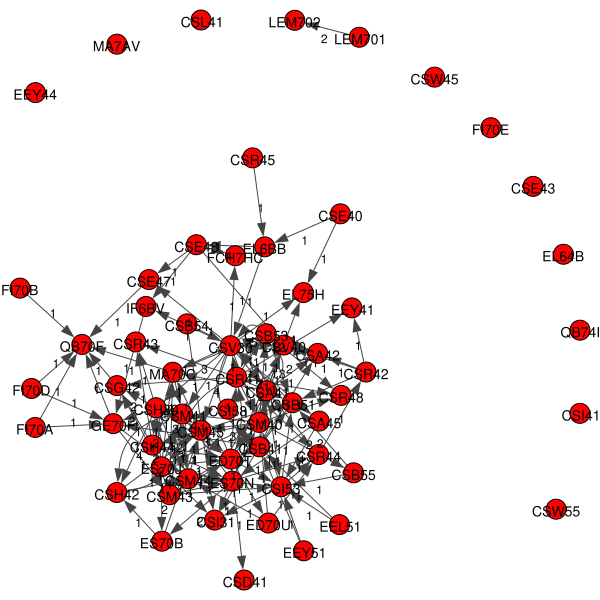

In [32]:
# layout = H.layout_davidson_harel()
# layout = H.layout_fruchterman_reingold()
# layout = H.layout_graphopt()
layout = H.layout_kamada_kawai()
# layout = H.layout_mds()
ig.plot(H, edge_label=H.es["weight"], layout=layout, vertex_label=H.vs["_nx_name"])
# print(H)

## Demonstração do Leiden


In [33]:
# partition = H.community_leiden (objective_function='CPM', resolution=)#, resolution=0.5, n_iterations=5)
# partition = H.community_leiden (objective_function='CPM', weights='weight')#, resolution=0.5, n_iterations=5)
partition_leiden = H.community_leiden(
    objective_function="modularity", weights="weight", resolution=4, n_iterations=5
)
ig.plot(partition_leiden)

InternalError: Error at src/community/leiden.c:989: Leiden algorithm is only implemented for undirected graphs. -- Invalid value

In [ ]:
comunidades_leiden = []
for com in partition_leiden:
    comunidades_leiden.append(H.vs.select(com)["_nx_name"])

for values in comunidades_leiden:
    df = (
        df_844.loc[df_844["CODIGO"].isin(values)]
        .groupby("CODIGO")
        .agg({"DISCIPLINA": "first", "TRILHA": "first"})
    )
    if df.size > 2:
        for value in values:
            printall(
                f"{value: >6} - {df.loc[value]['DISCIPLINA']:-<53} - {trilhas[df.loc[value]['TRILHA']]}"
            )
        print("---------------------------------------------------------------------")

 CSI58 - DATA MINING------------------------------------------ - Sistemas Inteligentes
 EEY51 - INSTRUMENTAÇÃO E TRANSDUÇÃO BIOMÉDICA I-------------- - Engenharia Biomédica
 EEL51 - FOTÔNICA--------------------------------------------- - Física
 CSB41 - BANCO DE DADOS 2------------------------------------- - Banco De Dados
---------------------------------------------------------------------
 CSB51 - RECUPERAÇÃO INTELIGENTE DE INFORMAÇÕES--------------- - Banco De Dados
 CSB55 - CIÊNCIA DE DADOS E MULTIDISCIPLINARIDADE------------- - Optativas Isoladas
---------------------------------------------------------------------
 CSI53 - MINERAÇÃO DE DADOS----------------------------------- - Sistemas Inteligentes
 EL64B - ELETROMAGNETISMO------------------------------------- - Optativas Isoladas
---------------------------------------------------------------------
 CSB53 - INTRODUÇÃO A CIÊNCIAS DE DADOS----------------------- - Banco De Dados
 CSA45 - GEOMETRIA COMPUTACIONAL------------------

In [ ]:
comunidades_leiden= []
for com in partition_leiden:
    comunidades_leiden.append(H.vs.select(com)["_nx_name"])

for values in comunidades_leiden:
    df = (
        df_844.loc[df_844["CODIGO"].isin(values)]
        .groupby("CODIGO")
        .agg({"DISCIPLINA": "first", "TRILHA": "first"})
    )
    # df_filtrado = df_844[df_844['CODIGO'].isin(values)]
    # df_filtrado['ID_ANONIMO'].nunique()
    # print(values)
    if df.size > 2:
        df_filtrado = df_844[df_844["CODIGO"].isin(values)].drop_duplicates(subset=["ID_ANONIMO", "CODIGO"])
        df_agrupado = df_filtrado.groupby('ID_ANONIMO').filter(lambda x: len(x) >= len(values))
        printall(df_filtrado)
        print(values)
        printall(df_agrupado)
    #     for value in values:
    #         printall(f"{value: >6} - {df.loc[value]['DISCIPLINA']:-<53} - {trilhas[df.loc[value]['TRILHA']]}")
        print("---------------------------------------------------------------------")

       ID_ANONIMO      CR PERIODO_CURSO   INGRESSO CODIGO   ANO  PERIODO_ANO NOTA  CH SITUACAOALUNO SEMESTRE                               DISCIPLINA TRILHA
20721      145077  0,7908            10 2017-02-03  CSI58  2022            2  9,5  45       Formado   2022.2                              DATA MINING    962
20726      145077  0,7908            10 2017-02-03  EEY51  2020            2  7,4  60       Formado   2020.2  INSTRUMENTAÇÃO E TRANSDUÇÃO BIOMÉDICA I    970
20738      145077  0,7908            10 2017-02-03  EEL51  2020            2    8  45       Formado   2020.2                                 FOTÔNICA    967
20752      145077  0,7908            10 2017-02-03  CSB41  2021            1  8,6  60       Formado   2021.1                         BANCO DE DADOS 2    968
22005      150887  0,8341            10 2017-02-03  CSB41  2021            1  6,8  60       Formado   2021.1                         BANCO DE DADOS 2    968
22162      151217  0,6949            10 2017-07-08  CSB41 

## Demonstração do Louvain


In [ ]:
partition_louvain = H.community_multilevel(weights="weight", resolution=10)

In [ ]:
comunidades_louvain = []
for com in partition_louvain:
    comunidades_louvain.append(H.vs.select(com)["_nx_name"])

for values in comunidades_louvain:
    df = (
        df_844.loc[df_844["CODIGO"].isin(values)]
        .groupby("CODIGO")
        .agg({"DISCIPLINA": "first", "TRILHA": "first"})
    )
    # df_filtrado = df_844[df_844['CODIGO'].isin(values)]
    # df_filtrado['ID_ANONIMO'].nunique()
    # print(values)
    if df.size > 2:
        df_filtrado = df_844[df_844["CODIGO"].isin(values)].drop_duplicates(subset=["ID_ANONIMO", "CODIGO"])
        df_agrupado = df_filtrado.groupby('ID_ANONIMO').filter(lambda x: len(x) >= len(values))
        printall(df_filtrado)
        print(values)
        printall(df_agrupado)
    #     for value in values:
    #         printall(f"{value: >6} - {df.loc[value]['DISCIPLINA']:-<53} - {trilhas[df.loc[value]['TRILHA']]}")
        print("---------------------------------------------------------------------")

       ID_ANONIMO      CR PERIODO_CURSO   INGRESSO CODIGO   ANO  PERIODO_ANO NOTA  CH SITUACAOALUNO SEMESTRE                               DISCIPLINA TRILHA
20721      145077  0,7908            10 2017-02-03  CSI58  2022            2  9,5  45       Formado   2022.2                              DATA MINING    962
20726      145077  0,7908            10 2017-02-03  EEY51  2020            2  7,4  60       Formado   2020.2  INSTRUMENTAÇÃO E TRANSDUÇÃO BIOMÉDICA I    970
20738      145077  0,7908            10 2017-02-03  EEL51  2020            2    8  45       Formado   2020.2                                 FOTÔNICA    967
['CSI58', 'EEY51', 'EEL51']
       ID_ANONIMO      CR PERIODO_CURSO   INGRESSO CODIGO   ANO  PERIODO_ANO NOTA  CH SITUACAOALUNO SEMESTRE                               DISCIPLINA TRILHA
20721      145077  0,7908            10 2017-02-03  CSI58  2022            2  9,5  45       Formado   2022.2                              DATA MINING    962
20726      145077  0,7908     

In [ ]:
df_844

,ID_ANONIMO,CR,PERIODO_CURSO,INGRESSO,CODIGO,ANO,PERIODO_ANO,NOTA,CH,SITUACAOALUNO,SEMESTRE,DISCIPLINA,TRILHA
20694,145077,"0,7908",10,2017-02-03,QB70E,2022,1,9,30,Formado,2022.1,CIÊNCIAS DO AMBIENTE,OBRIGATÓRIA
20695,145077,"0,7908",10,2017-02-03,ES70P,2020,2,"7,2",45,Formado,2020.2,FILOSOFIA DA CIÊNCIA E DA TECNOLOGIA,OBRIGATÓRIA
20696,145077,"0,7908",10,2017-02-03,MA71A,2017,1,"9,2",90,Formado,2017.1,CÁLCULO DIFERENCIAL E INTEGRAL 1,OBRIGATÓRIA
20697,145077,"0,7908",10,2017-02-03,FI72S,2018,1,"8,9",60,Formado,2018.1,FÍSICA TEÓRICA B,OBRIGATÓRIA
20698,145077,"0,7908",10,2017-02-03,FI72S,2017,2,4,60,Formado,2017.2,FÍSICA TEÓRICA B,OBRIGATÓRIA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49725,251700,"0,6279",2,2022-08-25,CSF13,2022,2,"4,2",90,Regular,2022.2,FUNDAMENTOS DE PROGRAMAÇÃO 1,OBRIGATÓRIA
49726,251700,"0,6279",2,2022-08-25,MA71A,2022,2,6,90,Regular,2022.2,CÁLCULO DIFERENCIAL E INTEGRAL 1,OBRIGATÓRIA
49727,251700,"0,6279",2,2022-08-25,FI71S,2022,2,"2,9",60,Regular,2022.2,FÍSICA TEÓRICA A,OBRIGATÓRIA
49728,251700,"0,6279",2,2022-08-25,MA71B,2022,2,6,90,Regular,2022.2,GEOMETRIA ANALÍTICA E ÁLGEBRA LINEAR,OBRIGATÓRIA
